In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

This notebook shows how to construct the number of excess deaths (relative to a counterfactual 2020) from ISTAT data on total deaths. It then compares these excess deaths to the counterfactual including Covid-19 deaths.

- The source for the ISTAT data is: https://www.istat.it/it/archivio/240401 $\to$ "Andamento dei decessi del 2020" $\to$ "Dataset analitico con i decessi giornalieri". 

- The source for the official Covid-19 deaths is https://github.com/pcm-dpc/COVID-19

# 1) Processing the mortality data

In [2]:
def convert_months(month):
    
    months = {}
    months['Abr'] = '04'
    months['Ago'] = '08'
    months['Dez'] = '12'
    months['Fev'] = '02'
    months['Jan'] = '01'
    months['Jul'] = '07'
    months['Jun'] = '06'
    months['Mai'] = '05'
    months['Mar'] = '03'
    months['Nov'] = '11'
    months['Out'] = '10'
    months['Set'] = '09'
    
    return months[month]

In [3]:
df = pd.read_csv('./mortality_data/Dados_SICO_2020-04-04.csv',
                 encoding = "UTF-8")

df = df[['Data (mm-dd)'] + ['{}'.format(yr) for yr in range(2015,2021)]].reset_index(drop=True).copy(deep=True)

df['aux'] = df['Data (mm-dd)'].str[:3]
df['month'] = df.aux.apply(lambda x: convert_months(x))
df['day'] = df['Data (mm-dd)'].str[-2:]
df['monthday'] = pd.to_numeric(df.month + df.day)
df['date'] = "2020-" + df['month'] + "-" + df['day']
df['date']  =  pd.to_datetime(df['date'] , format='%Y%m%d', errors='ignore')

df = df[['monthday'] + ['{}'.format(yr) for yr in range(2015,2021)] + ['date']]

dropping all dates before first covid death (march 16, start on the 15th)

In [4]:
first_day = 315
df = df[df['monthday'] >= first_day].reset_index(drop=True).copy(deep=True)

computing cumulative totals

In [5]:
for i in range(2015, 2021):
    df['cs_{}'.format(i)] = df['{}'.format(i)].cumsum()
    del df['{}'.format(i)]

In [6]:
df

,monthday,date,cs_2015,cs_2016,cs_2017,cs_2018,cs_2019,cs_2020
0,315,2020-03-15,307.0,337,307.0,344.0,272.0,292.0
1,316,2020-03-16,610.0,625,650.0,662.0,612.0,628.0
2,317,2020-03-17,921.0,924,973.0,990.0,929.0,962.0
3,318,2020-03-18,1238.0,1259,1284.0,1325.0,1225.0,1275.0
4,319,2020-03-19,1587.0,1619,1581.0,1622.0,1547.0,1630.0
...,...,...,...,...,...,...,...,...
287,1227,2020-12-27,77950.0,84237,81223.0,83864.0,82735.0,NaN
288,1228,2020-12-28,78305.0,84676,81644.0,84202.0,83053.0,NaN
289,1229,2020-12-29,78611.0,85130,82033.0,84549.0,83406.0,NaN
290,1230,2020-12-30,78938.0,85594,82385.0,84891.0,83744.0,NaN


computing the average of the cumulative totals across 2015-2019

In [7]:
df['cs_avg_1519'] = df.loc[:,['cs_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df.drop(['cs_{}'.format(yr) for yr in range(2015,2020)], axis=1)

computing daily growth rates 2015-2019

In [8]:
df['daily_growth'] = df.cs_avg_1519 / df.cs_avg_1519 .shift(1)

extrapolating forward

In [9]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.monthday==first_day,'cs_2020'].values[0]

In [10]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'daily_growth']

In [11]:
df = df.drop(['cs_avg_1519', 'daily_growth'], axis=1)

creating a date column

In [12]:
df = df[~pd.isnull(df.cs_2020)]

# 2) Processing the covid data

In [13]:
official = pd.read_csv('./COVID19_data/data.csv')[['data', 'obitos']]

# move date one day backwards, as the report is from the previous day
official['data'] = official.data.shift(1)

official["month"] = official.data.str[3:5]
official["day"] = official.data.str[0:2]
official["monthday"] = pd.to_numeric(official.month + official.day)

official = official.rename(columns={"data": "date"})

official = official[official['monthday'] >= first_day]
official = official.reset_index(drop=True).copy(deep=True)

del official['date']

# 3) Merging and plotting

In [14]:
df_merge = pd.merge(df, official, on=['monthday'], how='right')
df_merge = df_merge.fillna(0)
df_merge['counterfactual_2020_covid'] = df_merge.counterfactual + df_merge.obitos

In [15]:
df_merge.index=df_merge.date
df_merge = df_merge[['cs_2020', 'counterfactual', 'counterfactual_2020_covid']]

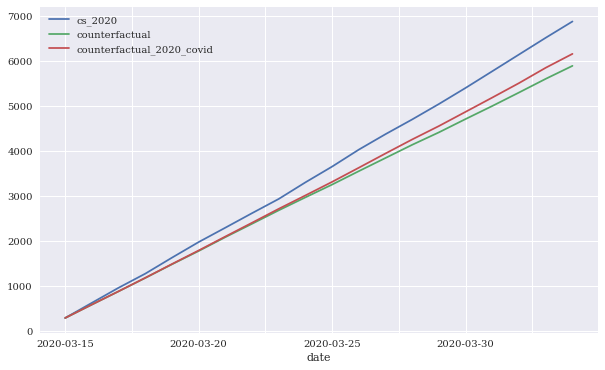

In [16]:
df_merge.plot(figsize=(10,6))
plt.show()

In [17]:
print('Official covid-deaths: {} = red-green'.format(round(df_merge.iloc[-1, 2] - df_merge.iloc[-1, 1])))
print('Excess deaths: {} = blue-green'.format(round(df_merge.iloc[-1, 0] - df_merge.iloc[-1, 1])))
print('Unexplained excess deaths: {} = blue-red'.format(round(df_merge.iloc[-1, 0] - df_merge.iloc[-1, 2])))

Official covid-deaths: 266.0 = red-green
Excess deaths: 984.0 = blue-green
Unexplained excess deaths: 718.0 = blue-red
